In [1]:
import numpy as np
import os
import PIL.Image as Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input


from tensorflow.keras.preprocessing import image

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [2]:
TRAIN_DIR = "/Users/Mareikes/Desktop/Wahlpflicht_AI/projekt_emotions/emotion_dataset/datasets/train"

In [ ]:
from pathlib import Path
# Zielpfad definieren (relativ zum Skript)
OUT_DIR = Path("../output")
OUT_DIR.mkdir(parents=True, exist_ok=True)  # Ordner erstellen, falls er noch nicht existiert

### Training

In [3]:
class_names = sorted(os.listdir(TRAIN_DIR))
num_classes = len(class_names)

In [9]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 2000 files belonging to 5 classes.
Using 1600 files for training.
Found 2000 files belonging to 5 classes.
Using 400 files for validation.


In [11]:
#konfigurieren
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)



In [12]:
#Augmenatation nicht zu viel, da Gesichter
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])


In [13]:
#Transfer Learning Modell aufbauen
base_model = MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # zunächst einfrieren

model = tf.keras.Sequential([
    tf.keras.Input(shape=IMG_SIZE + (3,)),
    data_augmentation,
    layers.Lambda(preprocess_input),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation="softmax")
])


In [14]:
#kompilieren, optimizer, loss und Metrik bestimmen
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['acc'])

In [15]:
#modell anzeigen
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [16]:
# Early Stopping Callback
early_stopping = EarlyStopping(
    monitor="val_loss", 
    patience=5, 
    restore_best_weights=True 
)

#Lernrate überwachen
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Überwacht die Validierungs-Fehler
    factor=0.5,            # Halbiert die Lernrate
    patience=5,            # Nach 5 Epochen ohne Verbesserung
    min_lr=1e-6            # Untere Grenze der Lernrate
)

# Checkpoint zum speichern
out_path = OUT_DIR / f'transfer_v1_16.keras'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    out_path,
    save_best_only=True,
    monitor="val_loss",
    mode="min"
)


In [17]:
#training starten
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs= 40,
  callbacks=[early_stopping, reduce_lr, checkpoint]
)

Epoch 1/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - acc: 0.2600 - loss: 1.7907 - val_acc: 0.3850 - val_loss: 1.5446 - learning_rate: 0.0010
Epoch 2/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 88s 880ms/step - acc: 0.4486 - loss: 1.4155 - val_acc: 0.4600 - val_loss: 1.3148 - learning_rate: 0.0010
Epoch 3/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 822ms/step - acc: 0.4756 - loss: 1.2840 - val_acc: 0.4575 - val_loss: 1.3569 - learning_rate: 0.0010
Epoch 4/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 85s 850ms/step - acc: 0.4973 - loss: 1.2255 - val_acc: 0.4800 - val_loss: 1.3023 - learning_rate: 0.0010
Epoch 5/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 72s 715ms/step - acc: 0.5395 - loss: 1.1639 - val_acc: 0.4650 - val_loss: 1.3250 - learning_rate: 0.0010
Epoch 6/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 68s 678ms/step - acc: 0.5563 - loss: 1.1495 - val_acc: 0.4975 - val_loss: 1.2724 - learning_rate: 0.0010
Epoch 7/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 71s 714ms/step - acc: 0.5550 - loss: 1.1240 - val_acc: 0.5200 - val_loss: 1.2268 - learning_

### Trainingsverlauf visuell darstellen

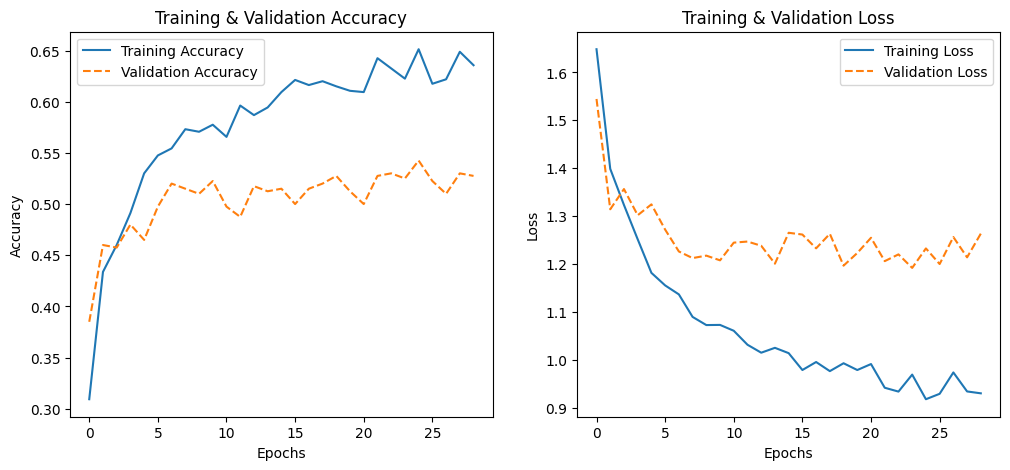

In [18]:
# Trainingsergebnisse aus dem `history`-Objekt extrahieren
history_dict = history.history

# Accuracy (Genauigkeit)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dict['acc'], label='Training Accuracy')
plt.plot(history_dict['val_acc'], label='Validation Accuracy', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

# Loss (Fehlerrate)
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.show()

### Evaluierung

In [19]:
TEST_DIR = "/Users/Mareikes/Desktop/Wahlpflicht_AI/projekt_emotions/emotion_dataset/datasets/test"

In [20]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  TEST_DIR,
  seed=42,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE) 

Found 500 files belonging to 5 classes.


In [24]:
#Funktion für confusion matrix
def show_confusion_matrix(cm, labels):
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, xticklabels=labels, yticklabels=labels, 
              annot=True, fmt='g')
  plt.xlabel('Prediction')
  plt.ylabel('Label')
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2025-05-18 23:06:11.154623: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


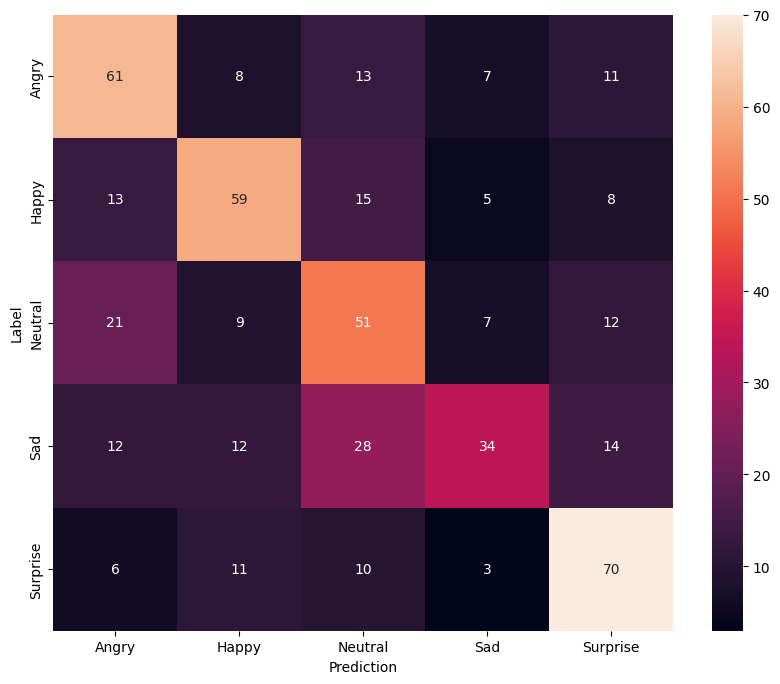

              precision    recall  f1-score   support

       Angry       0.54      0.61      0.57       100
       Happy       0.60      0.59      0.59       100
     Neutral       0.44      0.51      0.47       100
         Sad       0.61      0.34      0.44       100
    Surprise       0.61      0.70      0.65       100

    accuracy                           0.55       500
   macro avg       0.56      0.55      0.54       500
weighted avg       0.56      0.55      0.54       500



In [28]:
# Vorhersagen & Labels sammeln
all_labels = []
all_preds = []

for images, labels in test_ds:
    preds = model.predict(images)
    pred_classes = tf.argmax(preds, axis=-1)
    all_labels.extend(labels.numpy())
    all_preds.extend(pred_classes.numpy())

# Confusion Matrix & Klassifikationsbericht
cm = confusion_matrix(all_labels, all_preds)
show_confusion_matrix(cm, class_names)
print(classification_report(all_labels, all_preds, target_names=class_names))

### Vorhersagen visualisieren

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


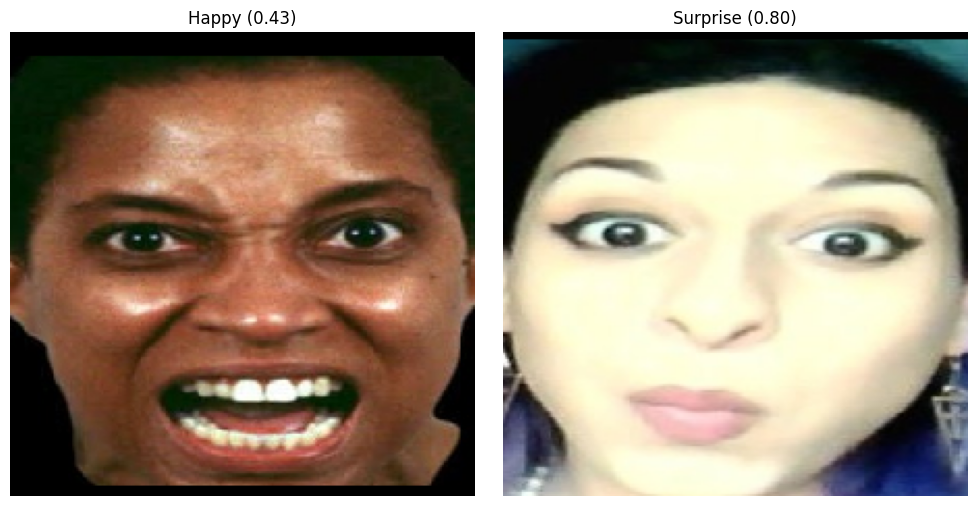

In [27]:
# Klassen definieren (anpassen)
class_names = np.array(['Angry', 'Happy', 'Neutral', 'Sad', 'Surprise'])


# Bildgröße
img_height, img_width = 224, 224

# Zwei zufällige Bilder auswählen
image_paths = []
for root, _, files in os.walk(TEST_DIR):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(root, file))

image_paths = np.random.choice(image_paths, 2, replace=False)

# Visualisierung mit Vorhersage
plt.figure(figsize=(10, 5))
for i, path in enumerate(image_paths):
    img = image.load_img(path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)

    # WICHTIG: Kein weiteres preprocess_input mehr nötig – Lambda-Schicht ist im Modell enthalten
    predictions = model.predict(img_batch)
    probabilities = predictions[0]

    predicted_class = np.argmax(probabilities)
    confidence = probabilities[predicted_class]

    plt.subplot(1, 2, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{class_names[predicted_class]} ({confidence:.2f})")
plt.tight_layout()
plt.show()
